# Template Molecule-based Temperature Map
## December 6, 2021

Should comment this extesively.

## Index 

 * [Step 1: Retrieve data on lines](##Step-1:-Retrieve-data-on-lines)
 * [Step 2: Generate noise map](##Step-2:-Generate-noise-map)
 * [Step 3: Generate N_upper from mom0, propagate errors](##Step-3:-Generate-N_upper-from-mom0,-propagate-errors)
 * [Step 4: Prepare for fitting temperature and N_tot, filtration step](##Step-4:-Prepare-for-fitting-temperature-and-N_tot,-filtration-step)
 * [Step 5: Fit temperature and N_tot](##Step-5:-Fit-temperature-and-N_tot)
 * [Step 6: Loop over each pixel to make maps](##Step-6:-Loop-over-each-pixel-to-make-maps)
 * [Step 7: Check rotational diagrams for individual pixels](##Step-7:-Check-rotational-diagrams-for-individual-pixels)


In [1]:
%matplotlib inline

import pylab as pl
# pl.style.use('dark_background')
# pl.rcParams['figure.facecolor'] = 'w'

# plt.rc('text', usetex = True) # Use LaTeX font in plots
# plt.rc('font', family = 'serif')
# plt.rcParams['text.latex.preamble'] = r'\usepackage{gensymb}'
# pl.rcParams.update({'font.size': 12})
display_dpi = 150

## Step 1: Retrieve data on lines

First, we'll retrieve some values we need for each rung from the methyl cyanide cube table.

In [2]:
from spectral_cube import SpectralCube
from astropy import units as u
from lte_modeling_tools import get_molecular_parameters
from astropy import constants

# User inputs
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '146_spw51'
fmin = 147.035*u.GHz # ch3cncube.spectral_axis.min() # I should not have to hard-code these...
fmax = 147.175*u.GHz # ch3cncube.spectral_axis.max()

In [3]:
def retrieve_cube(results, freq_spw):
    '''Get methyl cyanide (target molecule) cube'''
    fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
    ch3cncube = SpectralCube.read(fn, format='casa_image')
    ch3cn_freqs, ch3cn_A, ch3cn_g, ch3cn_E_U, ch3cn_partfunc = get_molecular_parameters('CH3CN',
                                                                                        fmin=fmin, 
                                                                                        fmax=fmax, 
                                                                                        catalog='JPL')
    # We're readying the partition function for use with temperature map later!
    ch3cn_A = 10**ch3cn_A*u.s**-1 # Original is log_10(A_ij)
    # DO NOT RUN THE FOLLOWING LINE, WHATEVER YOU DO
    #ch3cn_E_U = ch3cn_E_U/constants.k_B # Original is in erg
    return ch3cncube, ch3cn_freqs, ch3cn_A, ch3cn_g, ch3cn_E_U, ch3cn_partfunc

In [4]:
ch3cncube, ch3cn_freqs, ch3cn_A, ch3cn_g, ch3cn_E_U, ch3cn_partfunc = retrieve_cube(results, freq_spw)

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


## Step 2: Generate noise map

Now, we'll import the noise map, from which we'll begin error propagation.

In [5]:
from pylab import imshow
from astropy.io import fits

In [6]:
def generate_noise_map():
    '''Generate noise map from filename (hard-coded)'''
    hdu = fits.open('methyl_cyanide/template_noise.fits')
    noise_map = hdu[0].data
    imshow(noise_map, origin='lower')
    return noise_map

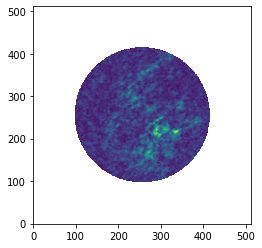

In [7]:
noise_map = generate_noise_map()

## Step 3: Generate N_upper from mom0, propagate errors

Should rework this so it doesn't use indices. I did this in the "synthetic spectrum" part of the code in new_temperature_map_messed_up_by_adam or something like that.

Now, we'll go through each rung of the ladder and get the upper state column density from the moment 0 map for each rung. We'll store those upper state column density maps for fitting in the next step, and we'll plot the moment 0 maps next to the upper state column density maps for each *k*-component.

We will also propagate errors on the noise map for each of the *k*-components.

In [8]:
import numpy as np
from lte_modeling_tools import nupper_of_kkms
from astropy import constants
import matplotlib.pyplot as plt

In [9]:
def generate_N_upper(ch3cn_freqs, ch3cn_A, ch3cn_g):
    '''Get upper state column density maps from filenames (hard-coded)'''
    log_N_upper_gs = []
    log_N_upper_g_errs = []

    i = 0
    for i in range(0, 8):

        # Import masked cube and get channel width
        masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_{i}_masked.fits', format='fits')
        channel_width = np.diff(masked_cube.spectral_axis)[0]

        # Calculate moment 0 and moment 1 maps of cube
        mom0 = masked_cube.moment0()
        mom1 = masked_cube.moment1()
        # Propagate error on integrated intensity
        noise_map_int = noise_map*u.K*(channel_width)

        # Calculate what the shifted line frequency for the rung should be (per pixel) with mom1
        #shifted_line_freqs = (ch3cn_freqs[i]-((mom1/(constants.c.to(u.km/u.s)))*ch3cn_freqs[i])).to(u.GHz) # Maybe okay?

        # Calculate upper state column density from integrated line intensity (moment 0 map)
        N_upper = nupper_of_kkms(mom0, ch3cn_freqs[i], ch3cn_A[i])
        log_N_upper_g = np.log10(N_upper.value/ch3cn_g[i]) # Shouldn't have to do .value?
        # Propagate error on upper state column density
        N_upper_err = nupper_of_kkms(noise_map_int, ch3cn_freqs[i], ch3cn_A[i])
        log_N_upper_g_err = N_upper_err/(N_upper*np.log(10.)) # There's no g here b/c it's a constant?

        # Append upper state column density maps and error maps into lists
        log_N_upper_gs.append(log_N_upper_g)
        log_N_upper_g_errs.append(log_N_upper_g_err)

        # Plot moment 0 and upper state column density maps for each rung next to each other
    #     fig = plt.figure(figsize = (20, 10))
    #     im = plt.subplot(1,2,1).imshow(mom0.value, origin='lower', cmap='magma')
    # #     plt.colorbar(mappable = im)
    #     plt.title(f"Methyl Cyanide $j = 8$, $k = {i}$ Moment 0 Map")
    #     im = plt.subplot(1,2,2).imshow(log_N_upper_g, origin='lower', cmap='magma')
    # #     plt.colorbar(mappable = im)
    #     plt.title(f"Methyl Cyanide $j = 8$, $k = {i}$ Upper State Column Density Map")
    #     plt.show()

        print(np.nanmin(log_N_upper_g))
        print(np.nanmax(log_N_upper_g))

        i += 1

    log_N_upper_gs = np.array(log_N_upper_gs)
    log_N_upper_g_errs = np.array(log_N_upper_g_errs)
    return log_N_upper_gs, log_N_upper_g_errs

In [10]:
log_N_upper_gs, log_N_upper_g_errs = generate_N_upper(ch3cn_freqs, ch3cn_A, ch3cn_g)

/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.771434330649637
11.203270624302668


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.199712014698397
10.544720186552167


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.356302266511364
10.304819955090995


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.2660491037275
10.484721220759784


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


8.905804559852566
9.748594891310265


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.169003615921326
9.721915584509986


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.147933134282438
9.744078555458074


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.142300432898672
9.640801543044526


## Step 4: Prepare for fitting temperature and N_tot, filtration step

Should clean this up.

In [11]:
# Convert to natural log for fitting
ln_N_upper_gs = np.log(10**(log_N_upper_gs))
ln_N_upper_g_errs = np.log(10**(log_N_upper_g_errs))

# Replace all NaNs with 0s
ln_N_upper_gs = np.nan_to_num(ln_N_upper_gs)
# Set the errors to be huge so these are ignored in the fit
ln_N_upper_g_errs = np.nan_to_num(ln_N_upper_g_errs, nan=1e10)

In [12]:
# Sum along k-component axis of NaN/non-NaN mask (which has True for "value," False for NaN)
# /where/ (not "if," as that invokes for loops) sum less than 3, make all values NaN (or 0)
ln_N_upper_gs.shape # (8, 512, 512)
ln_N_upper_gs_mask = ln_N_upper_gs != 0
# ln_N_upper_gs[ln_N_upper_gs_mask] # This does not have the shape I want, it's /just/ the valid values
ln_N_upper_gs_mask_sum = ln_N_upper_gs_mask.sum(axis=0)
ln_N_upper_gs_mask_sum_rep = np.repeat(ln_N_upper_gs_mask_sum[np.newaxis, :, :], 8, axis=0)

ln_N_upper_gs_test = ln_N_upper_gs.copy() # probably don't need to duplicate this?
ln_N_upper_gs_test[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # use boolean mask to apply to upper state col densities

ln_N_upper_gs[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # now officially applying to data! *****
ln_N_upper_g_errs[ln_N_upper_gs_mask_sum_rep <= 3] = 1e10 # errors big = try to ignore these

## Step 5: Fit temperature and N_tot

Let's fit a pixel!

In [13]:
# Don't fit missing data (SHOULD INCORP UPPER LIMITS)
col_density_NaN_mask = np.isfinite(ln_N_upper_gs[:,200,298]) # ignores NaNs
col_density_zero_mask = ln_N_upper_gs[:,200,298] != 0
fit_energies = (ch3cn_E_U[::-1])[col_density_zero_mask]
fit_col_densities = ln_N_upper_gs[:,200,298][col_density_zero_mask]

print(fit_energies)
print(fit_col_densities)

[4.38845933e-15 5.37496915e-15 1.32657764e-14 2.01682662e-14
 2.90402001e-14 3.98795720e-14]
[24.72986475 23.215439   23.16006282 21.05222209 21.69091685 21.2829733 ]


In [14]:
# do the simple linear fit
from scipy.optimize import curve_fit

def linear(x, m, b):
    return m*x + b

# CONVERT TO K FROM ERGS TO DO THE FIT BC ERGS HAD SMALL NUMBERS
fit_energies_converted = (fit_energies*u.erg/constants.k_B).decompose()

# guess = np.array([1e-15, 100])
popt, pcov = curve_fit(linear, fit_energies_converted, fit_col_densities) #,  guess
print(popt)
slope, intercept = popt[0], popt[1]

[-1.15769970e-02  2.40887861e+01]


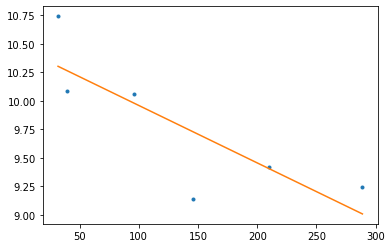

In [15]:
# x_axis = (fit_energies*u.erg/constants.k_B).decompose() # NOW X AXIS IS IN KELVIN
plt.plot(fit_energies_converted, np.log10(np.exp(fit_col_densities)), '.') 
plt.plot(fit_energies_converted, np.log10(np.exp(slope*fit_energies_converted.value+intercept)))

In [16]:
# extract the values
temp = (-1./slope)*u.K # okay, we are assuming that this is the correct interpretation of m vs. b
# temp = (temp*u.erg/constants.k_B).decompose() # DON'T NEED THIS BC FIT ALREADY DIVIDED BY K_B
total_col_density = np.log10(np.exp(intercept)*ch3cn_partfunc(temp))

print(f"Temp: {temp}")
print(f"log10(Total column density): {total_col_density}")

Temp: 86.37818599510024 K
log10(Total column density): 13.67987793581292


## Step 6: Loop over each pixel to make maps

Let's now loop this process for each pixel.

In [17]:
import tqdm
tqdm.__version__

'4.62.3'

In [18]:
from tqdm.notebook import tqdm

In [19]:
energy_K = (ch3cn_E_U[::-1]*u.erg/constants.k_B).decompose()

In [20]:
slope_map = np.zeros(ln_N_upper_gs.shape[1:])
intercept_map = np.zeros(ln_N_upper_gs.shape[1:])
for index in tqdm(np.ndindex(ln_N_upper_gs.shape[1:])):
    col_density = ln_N_upper_gs[:,index[0],index[1]]
    # Create column density mask, accounting for NaNs and zeros
    col_density_mask = (col_density != 0) & np.isfinite(col_density)
    if not col_density_mask.sum() > 1: # Are there unmasked values? If no, skip index
        continue 
    # Get energies and column densities for fit
    energy_for_fit = energy_K[col_density_mask]
    col_density_for_fit = col_density[col_density_mask]
    # Perform linear fit along k-component axis for valid values
    popt, pcov = curve_fit(linear, energy_for_fit, col_density_for_fit) #,  guess
    slope_map[index], intercept_map[index] = popt

0it [00:00, ?it/s]

In [21]:
# extract the values
temp_map = (-1./slope_map)*u.K
# temp = (temp*u.erg/constants.k_B).decompose() # DON'T NEED THIS BC FIT ALREADY DIVIDED BY K_B
total_col_density_map = np.log10(np.exp(intercept_map)*ch3cn_partfunc(temp_map))

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


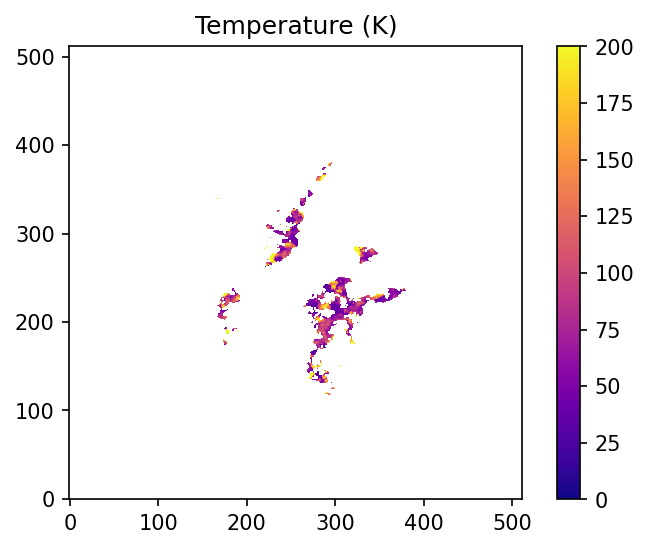

In [44]:
fig = plt.figure(dpi = display_dpi)
# rock = sns.color_palette("rocket", as_cmap=True)
cm = pl.matplotlib.cm.plasma.copy()
cm.set_under('w') # Make sure the "zero" color is white
pl.imshow(temp_map.value, vmax=200, vmin=0, cmap = cm, origin='lower')
pl.title('Temperature (K)')
pl.colorbar()
pl.savefig("../figures/temp_map.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')

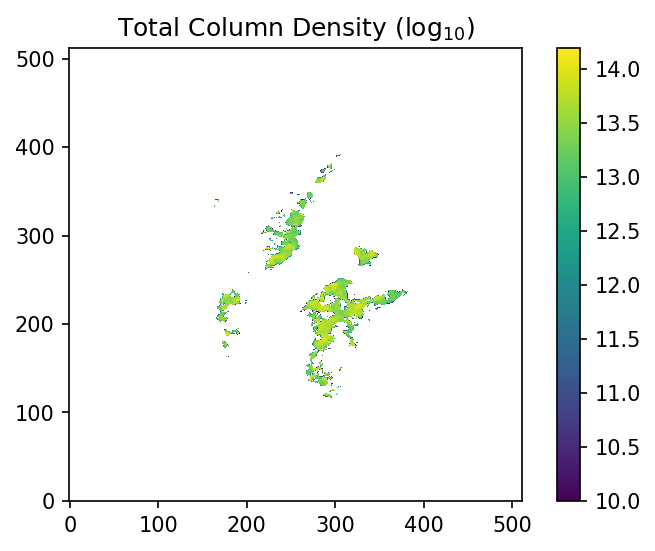

In [45]:
fig = plt.figure(dpi = display_dpi)
# mako_r = sns.color_palette("mako_r", as_cmap=True)
cm = pl.matplotlib.cm.viridis.copy()
cm.set_under('w') # Make sure the "zero" color is white
pl.imshow(total_col_density_map, vmin=10, cmap = cm, origin='lower')
pl.title('Total Column Density ($\log_{10}$)')
pl.colorbar()
pl.savefig("../figures/coldens_map.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')

## Step 7: Check rotational diagrams for individual pixels
Code copied directly from Step 5.

In [25]:
from scipy.optimize import curve_fit

In [26]:
def rotational_diagram(pixel_x, pixel_y):
    fig = plt.figure(dpi = display_dpi)
    #  Don't fit missing data (SHOULD INCORP UPPER LIMITS)
    col_density_NaN_mask = np.isfinite(ln_N_upper_gs[:,pixel_y,pixel_x]) # ignores NaNs
    col_density_zero_mask = ln_N_upper_gs[:,pixel_y,pixel_x] != 0
    fit_energies = (ch3cn_E_U[::-1])[col_density_zero_mask]
    fit_col_densities = ln_N_upper_gs[:,pixel_y,pixel_x][col_density_zero_mask]
#     print(fit_energies, fit_col_densities)
    
    # do the simple linear fit
    # CONVERT TO K FROM ERGS TO DO THE FIT BC ERGS HAD SMALL NUMBERS
    fit_energies_converted = (fit_energies*u.erg/constants.k_B).decompose()
    # guess = np.array([1e-15, 100])
    popt, pcov = curve_fit(linear, fit_energies_converted, fit_col_densities)
#     print(popt)
    slope, intercept = popt[0], popt[1]
    
    # extract the values
    temp = (-1./slope)*u.K # okay, we are assuming that this is the correct interpretation of m vs. b
    # temp = (temp*u.erg/constants.k_B).decompose() # DON'T NEED THIS BC FIT ALREADY DIVIDED BY K_B
    total_col_density = np.log10(np.exp(intercept)*ch3cn_partfunc(temp))

    # x_axis = (fit_energies*u.erg/constants.k_B).decompose() # NOW X AXIS IS IN KELVIN
    pl.plot(fit_energies_converted, np.exp(fit_col_densities), 'o', color = 'tab:blue') 
    pl.plot(fit_energies_converted, np.exp(slope*fit_energies_converted.value+intercept), 
            label = f"$T$ = {temp:.1f}, $\log_{{10}}(N_{{tot}})$ = {total_col_density:.2f}",
            color = 'tab:orange')
    pl.yscale('log')
    pl.title(f"Rotational diagram for ({pixel_x}, {pixel_y})")
    pl.xlabel("Upper state energy (K)")
    pl.ylabel(r"Column density (cm$^{-2}$)")
    pl.legend()
    pl.show()

    # print extracted values
    print(f"Temp: {temp:.5f}")
    print(f"log10(Total column density): {total_col_density:.5f}")

def linear(x, m, b):
    return m*x + b

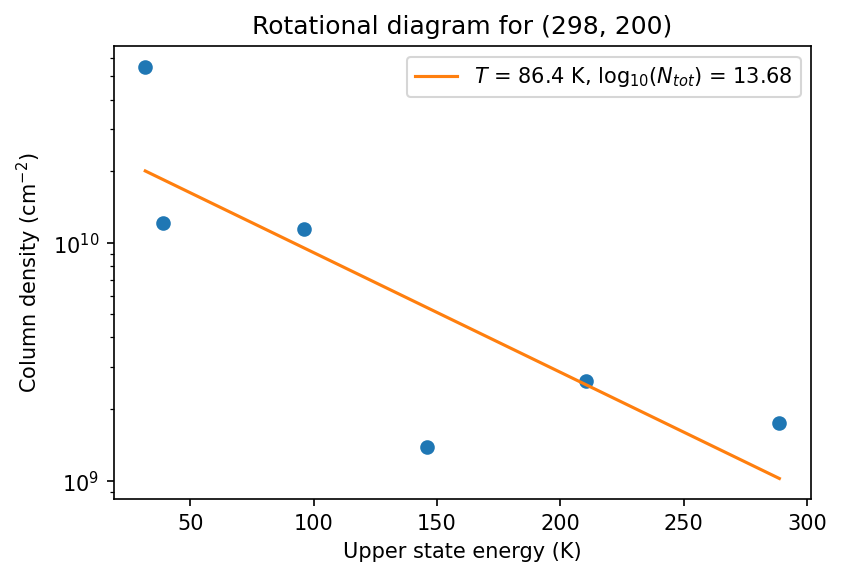

Temp: 86.37819 K
log10(Total column density): 13.67988


<Figure size 432x288 with 0 Axes>

In [27]:
rotational_diagram(298, 200)
pl.savefig("../figures/rot_diagram.pdf", dpi = 200, facecolor='w', edgecolor='w', bbox_inches='tight')

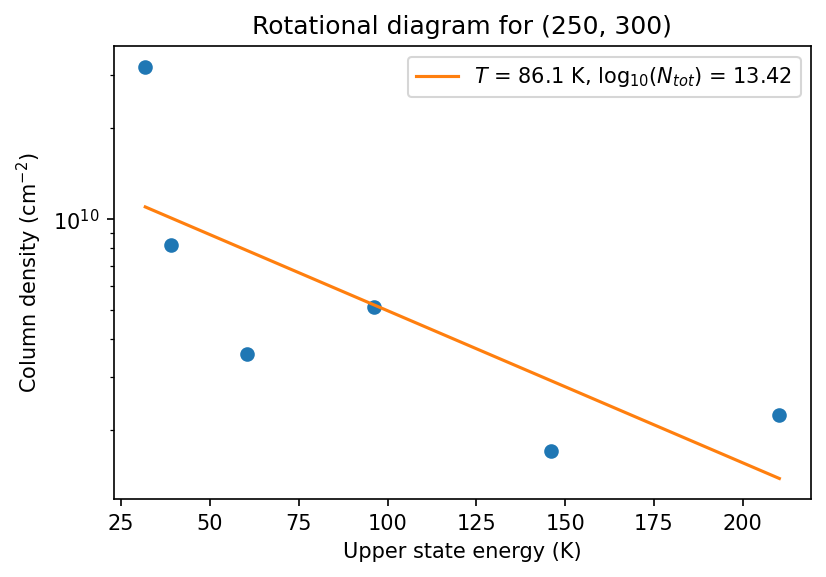

Temp: 86.06726 K
log10(Total column density): 13.41654


In [28]:
rotational_diagram(250, 300)

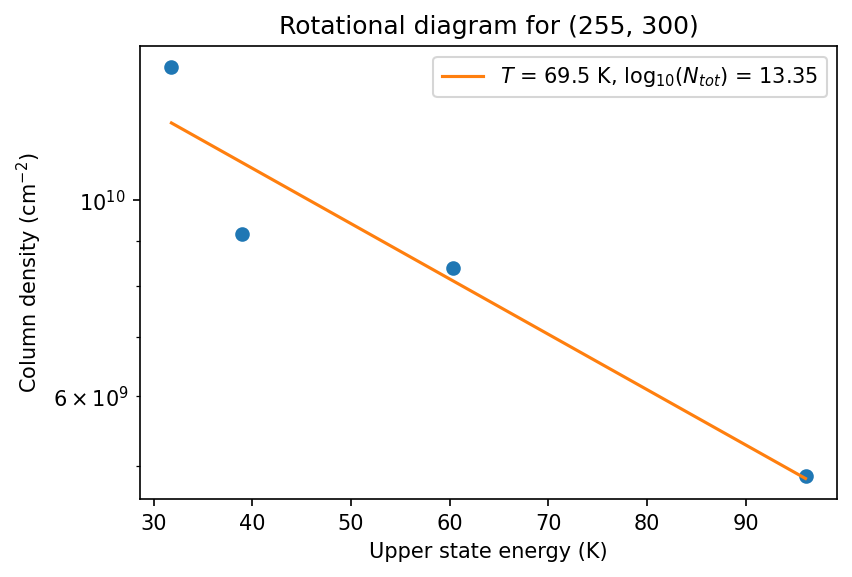

Temp: 69.47157 K
log10(Total column density): 13.34560


In [29]:
rotational_diagram(255, 300)

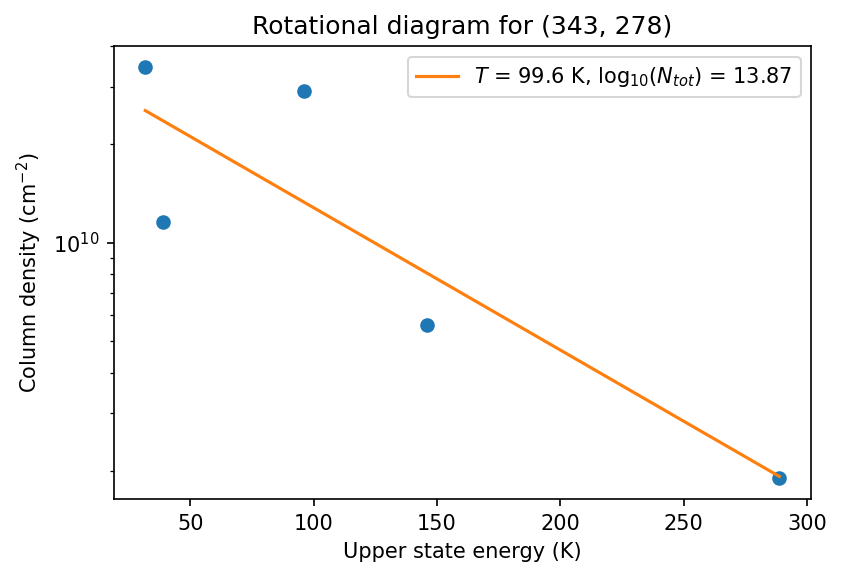

Temp: 99.62705 K
log10(Total column density): 13.86576


In [30]:
rotational_diagram(343, 278)

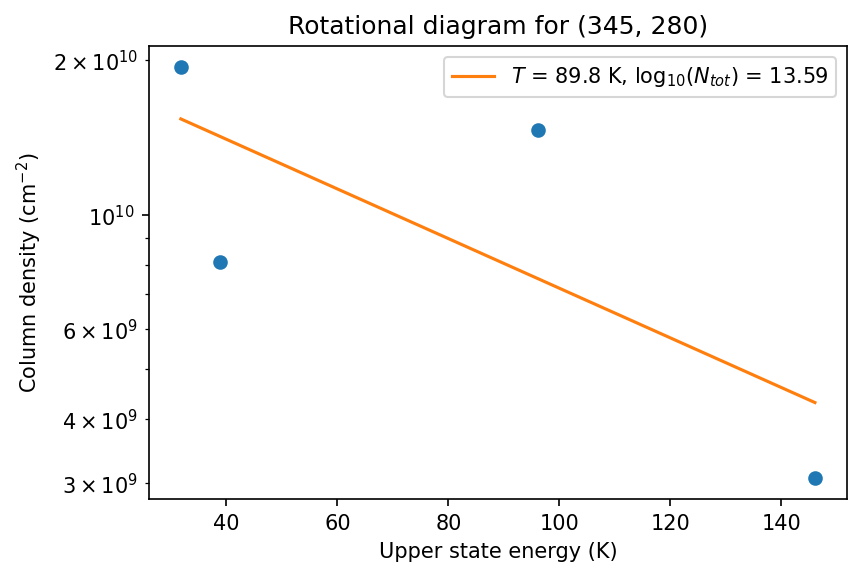

Temp: 89.80843 K
log10(Total column density): 13.58862


In [31]:
rotational_diagram(345, 280)

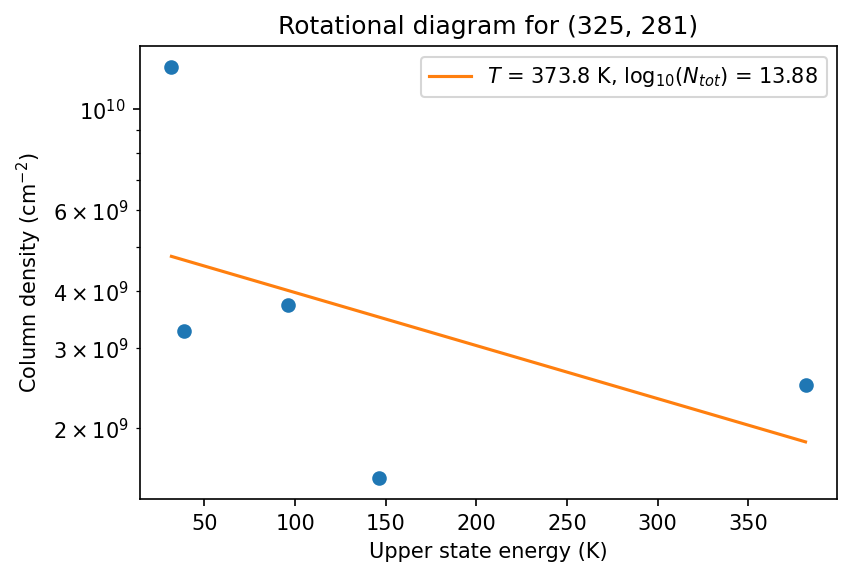

Temp: 373.77163 K
log10(Total column density): 13.88118


In [32]:
rotational_diagram(325, 281)

## Step 8: Generate synthetic spectrum for a pixel, and compare to original spectrum

In [33]:
# Retrieve and plot original spectrum for one of these pixels (takes a while to run)
test_pixel_x, test_pixel_y = 250, 300
spectrum = ch3cncube[:,test_pixel_y,test_pixel_x]

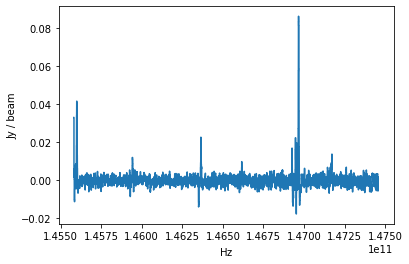

In [34]:
# Plot original spectrum for one of these pixels
spectrum.quicklook()

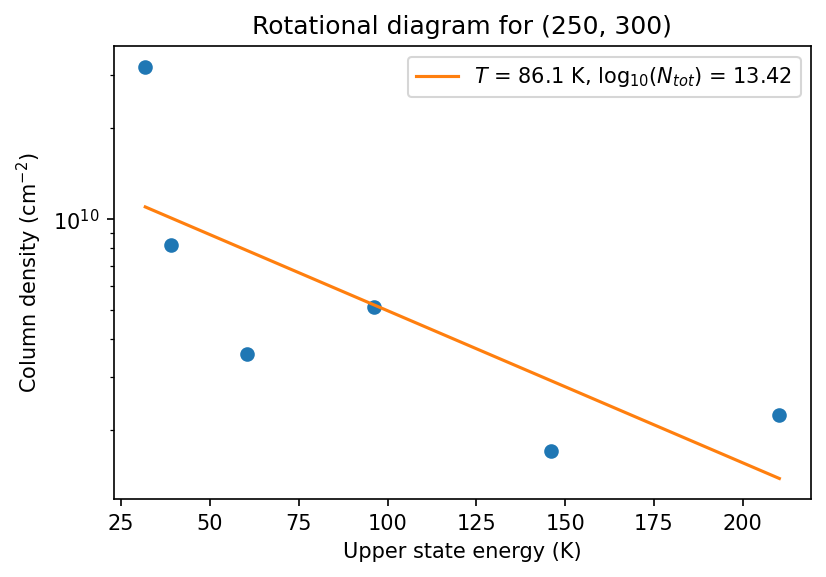

Temp: 86.06726 K
log10(Total column density): 13.41654


In [35]:
# Print temp/col density inputs from fit for this pixel
rotational_diagram(test_pixel_x, test_pixel_y)

In [36]:
%%capture
# Generate synthetic spectrum for this cube, making sure to use temp/col density inputs from fit
%run /blue/adamginsburg/abulatek/brick/first_results/LTE/reworked_LTE_lineforest.py

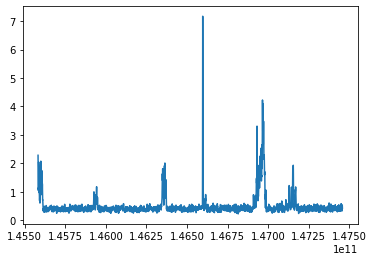

In [37]:
pl.plot(sp.xarr, sp.data)

Text(0, 0.5, 'Data minus model (maybe not same units?)')

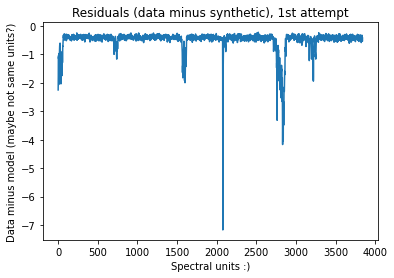

In [38]:
pl.plot(spectrum.value-np.array(sp.data))
pl.title("Residuals (data minus synthetic), 1st attempt")
pl.xlabel("Spectral units :)")
pl.ylabel('Data minus model (maybe not same units?)')